Huge Stock Market Dataset in kaggle

In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List


In [2]:
#Analysis (of course!) data about APPLE
df = pd.read_csv("aapl.us.txt",parse_dates=["Date"])

In [3]:
df.shape

(8364, 7)

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [6]:
#period of date 
df["Date"].min(),df["Date"].max()

(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

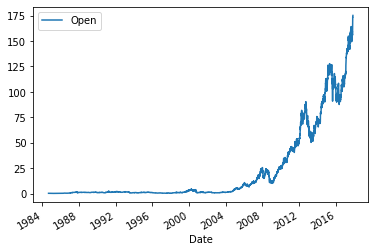

In [7]:
df.plot(x="Date",y="Open")

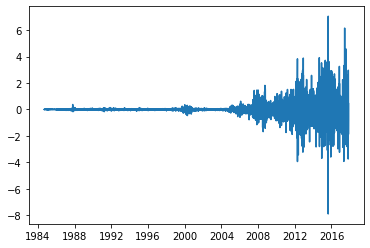

In [17]:
y =df["Open"]-df["Close"]
x =df["Date"] 
plt.plot(x,y)


In [18]:
df[["Open","Close","Low","High"]].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


All prices are correlated and therefore linearly dependent

In [19]:
#Let's take the data for the last 10 years, when the company went up
df_10_yr = df[df["Date"]>df["Date"].max() - timedelta(days= 365 * 10)]

In [20]:
df_10_yr.shape

(2517, 7)

In [21]:
df_10_yr["Date"].min(),df_10_yr["Date"].max()

(Timestamp('2007-11-14 00:00:00'), Timestamp('2017-11-10 00:00:00'))

7

In [24]:
#We work with time series. 
#Therefore, it is important that the training events take place before the validation ones

#You can use the sclearn library - train_test_split
#I did it for clarity
train_size = int(df_10_yr.shape[0] * 0.8)
train_df = df_10_yr.iloc[:train_size]
val_df = df_10_yr.iloc[train_size:]


In [25]:
train_df.shape,val_df.shape

((2013, 7), (504, 7))

In [28]:
print(train_df["Date"].min(),train_df["Date"].max())
print(val_df["Date"].min(),val_df["Date"].max())

2007-11-14 00:00:00 2015-11-11 00:00:00
2015-11-12 00:00:00 2017-11-10 00:00:00


In [30]:
#for effective learning
scaler = StandardScaler()
scaler.fit(train_df[["Low"]])
# window_size - the number of elements that are used for prediction
def make_dataset(df,window_size,batch_size,
                 use_scaler=True,
                 shuffle=True):
  features = df[["Low"]].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features,dtype=np.float32)
  data_set = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=df["Low"].iloc[window_size:],
      sequence_length=window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size)
  return data_set

In [32]:
#use without shuffle and scaler
window_size1 = 10
batch_size1 = 8
train_data_set = make_dataset(df=train_df,window_size=window_size1,batch_size=batch_size1,use_scaler=False,shuffle=False)
val_data_set = make_dataset(df=val_df,window_size=window_size1,batch_size=batch_size1,use_scaler=False,shuffle=False)

In [33]:
#creating a sequential neural network

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(32,return_sequences=False),
                                         tf.keras.layers.Dense(1)])

In [44]:
def compile_and_fit_model(model,train,val):
  epochs = 100
  model.compile(loss = tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  #training,without intermediate information(verbose=0)
  history = model.fit(train,epochs=epochs,validation_data=val,verbose=0)
  return history

In [38]:
history = compile_and_fit_model(lstm_model,train_data_set, val_data_set)

In [39]:
lstm_model.evaluate(train_data_set)

250/250 [==============================] - 1s 5ms/step - loss: 45.2782 - mean_absolute_error: 5.9597


[45.27816390991211, 5.9596967697143555]

In [40]:
lstm_model.evaluate(val_data_set)

61/61 [==============================] - 0s 6ms/step - loss: 437.1112 - mean_absolute_error: 15.8886


[437.1112060546875, 15.888603210449219]

we had a (large-compared to the training sample)retraining.
Therefore, we use dropout


In [45]:
lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(32,return_sequences=False),
                                         tf.keras.layers.Dropout(0.2),
                                         tf.keras.layers.Dense(1)])
history = compile_and_fit_model(lstm_model,train_data_set, val_data_set)

In [46]:
lstm_model.evaluate(train_data_set)

250/250 [==============================] - 1s 5ms/step - loss: 4.3246 - mean_absolute_error: 1.3456


[4.324565887451172, 1.3456262350082397]

In [47]:
lstm_model.evaluate(val_data_set)

61/61 [==============================] - 1s 6ms/step - loss: 326.1897 - mean_absolute_error: 12.0781


[326.1897277832031, 12.078108787536621]

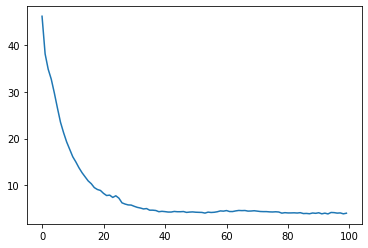

In [48]:
plt.plot(history.history["mean_absolute_error"])

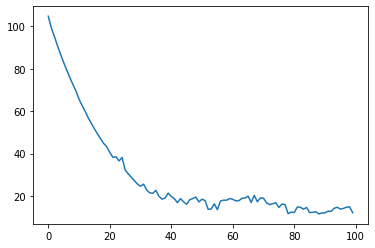

In [50]:
plt.plot(history.history["val_mean_absolute_error"])

There is an assumption that we took data from too big a jump, so we had to take training not for 10 years, but for 5-6